# Multi-armed Bandits

In [1]:
!pip install numpy
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import library

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

## Algorithm K multi-armed-bandit

In [37]:
class Bandit:
    def __init__(self, epsilon = 0.1, UCB = 2 ,k_arm=10, strategy ='epsilon-greedy', update_mode='average', initial = 0, learning_rate = 0.1, alpha = 0.1):
        self.k = k_arm
        self.time = 0
        self.strategy = strategy
        self.epsilon = epsilon
        self.UCB = UCB
        self.initial = initial
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.update_mode = update_mode

    def reset(self):
        # reward for each action: q_true
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true) 
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.H = np.ones(self.k)
        self.policy = np.zeros(self.k)
        self.total_reward = 0

    def choose_action(self):
        if self.strategy == 'epsilon-greedy':
            if np.random.rand() < self.epsilon:
                return np.random.randint(self.k)
            q_best = np.max(self.q_estimation)
            return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])
            
        if self.strategy == 'UCB':
            if np.all(self.action_count != 0):
                UCB_estimation = self.q_estimation + self.UCB * np.sqrt(np.log(self.time + 1) / self.action_count)
                q_best = np.max(UCB_estimation)
                return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])
            else:
                return np.random.choice([action for action in np.arange(self.k) if self.action_count[action] == 0])

        if self.strategy == 'gradient':
            def softmax(H):
                h = H - np.max(H)
                exp = np.exp(h)
                return exp / np.sum(exp)

            # Chọn hành động
            self.policy = softmax(self.H)
            action = int(np.random.choice(self.k, p=self.policy))
            return action

    def update(self, action):
        if self.strategy == 'gradient':
            reward = self.q_true[action] + np.random.randn()
            self.total_reward += reward
            self.time += 1
            self.action_count[action] += 1
            avg_reward = self.total_reward / self.time
            tmp = self.H[action] + self.alpha * (reward - avg_reward) * (1 - self.policy[action])
            self.H -= self.alpha * (reward - avg_reward) * self.policy
            self.H[action] = tmp

            return reward

        else:
            reward = self.q_true[action] + np.random.randn()
            self.time += 1
            self.action_count[action] += 1
            if self.update_mode == 'average':
                self.q_estimation[action] += 1.0 / self.action_count[action] * (reward - self.q_estimation[action])
            else:
                self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])
            return reward

In [38]:
def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.choose_action()
                reward = bandit.update(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    best_action_counts = best_action_counts.mean(axis=1)
    rewards = rewards.mean(axis=1)
    return best_action_counts, rewards

## Visualize Reward Distribution 

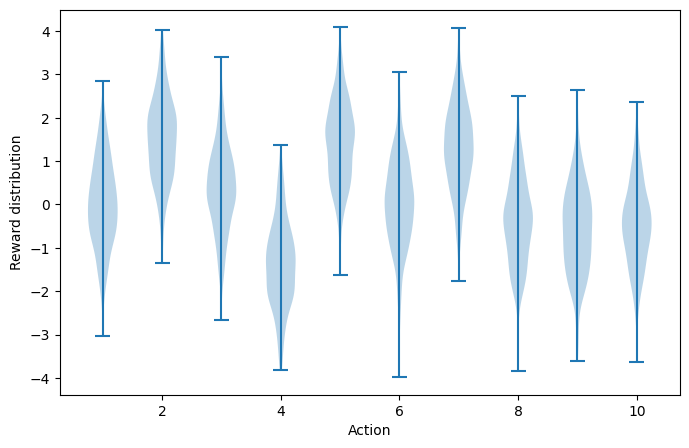

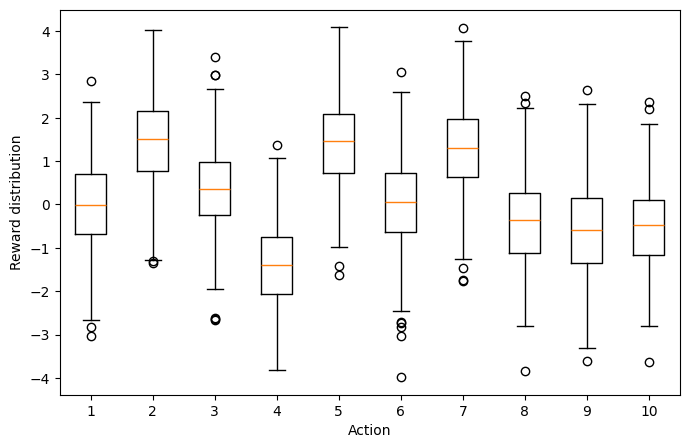

In [51]:
sample_reward_distribution = np.random.randn(500, 10) + np.random.randn(10)
plt.figure(figsize=(8,5))
plt.violinplot(dataset=sample_reward_distribution )
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()

plt.figure(figsize=(8,5))
plt.boxplot(sample_reward_distribution )
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()


In [26]:
runs=2000
time=1000

## Greedy Method

In [43]:
epsilons = [0, 0.01, 0.1]
bandits = [Bandit(epsilon = eps) for eps in epsilons]
best_action_counts,rewards = simulate(runs, time, bandits)

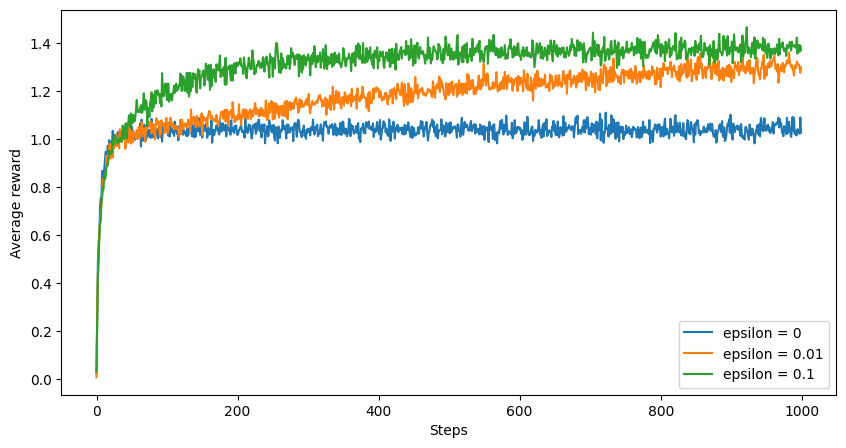

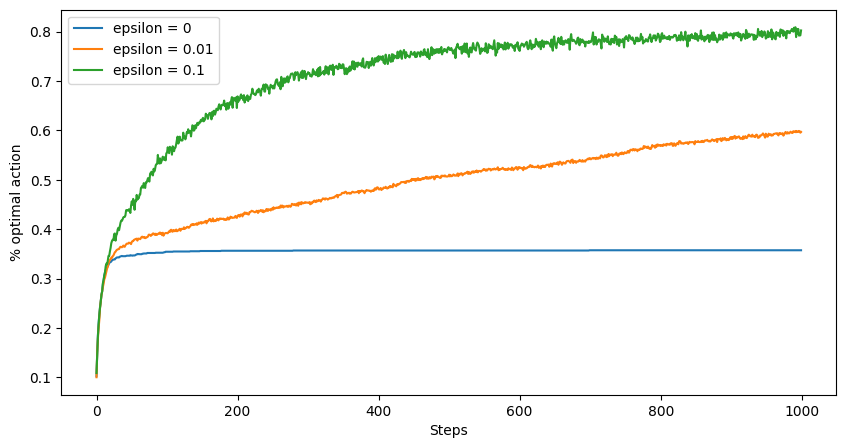

In [44]:
plt.figure(figsize=(10,5))
for eps, reward in zip(epsilons, rewards):
     plt.plot(reward, label='epsilon = {}'.format(eps))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='epsilon = {}'.format(eps))
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()
plt.show()
plt.close()

## Optimistic Initial Values Method

In [39]:
bandits_oiv = []
bandits_oiv.append(Bandit(initial = 0, epsilon = 0.1, update_mode='step_size'))
bandits_oiv.append(Bandit(initial = 5, epsilon = 0, update_mode='step_size'))
best_action_counts_oiv,rewards_oiv = simulate(runs, time, bandits_oiv)

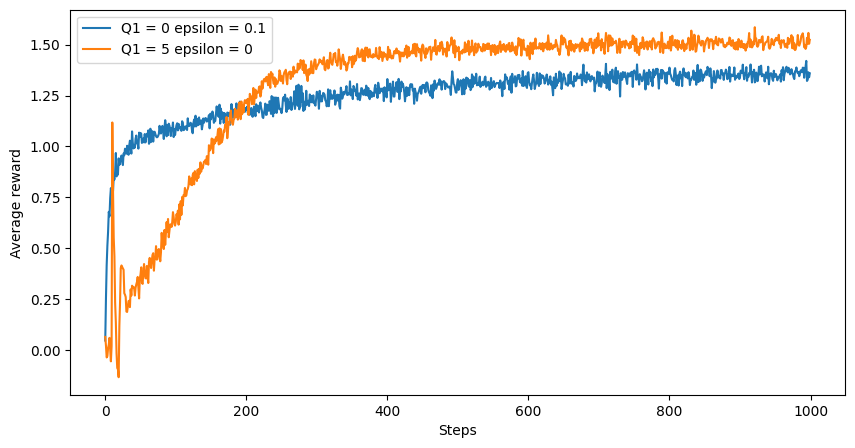

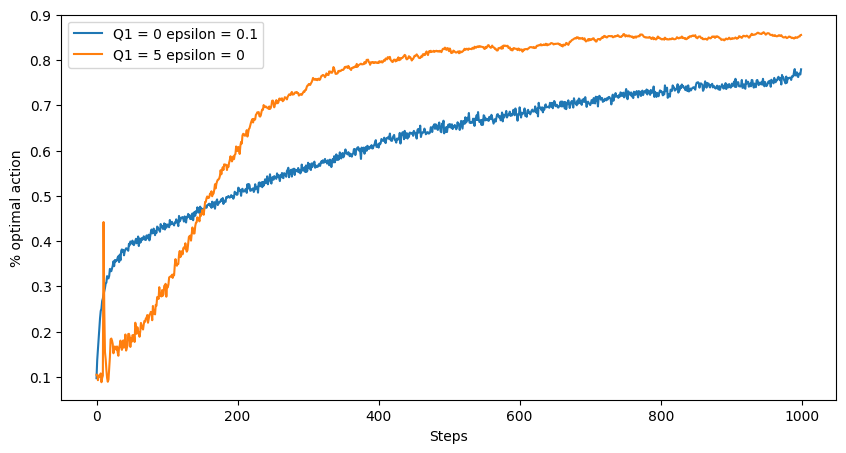

In [40]:
plt.figure(figsize=(10,5))
plt.plot(rewards_oiv[0], label='Q1 = {} epsilon = {}'.format(0, 0.1))
plt.plot(rewards_oiv[1], label='Q1 = {} epsilon = {}'.format(5, 0))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(best_action_counts_oiv[0], label='Q1 = {} epsilon = {}'.format(0, 0.1))
plt.plot(best_action_counts_oiv[1], label='Q1 = {} epsilon = {}'.format(5, 0))
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()
plt.show()
plt.close()


## Upper-Confidence-Bound Method

In [24]:
bandits_UCB = []
bandits_UCB.append(Bandit(strategy = 'UCB', UCB=2))
bandits_UCB.append(Bandit(strategy = 'epsilon-greedy', epsilon=0.1))
best_action_counts_UCB, rewards_UCB = simulate(runs, time, bandits_UCB)

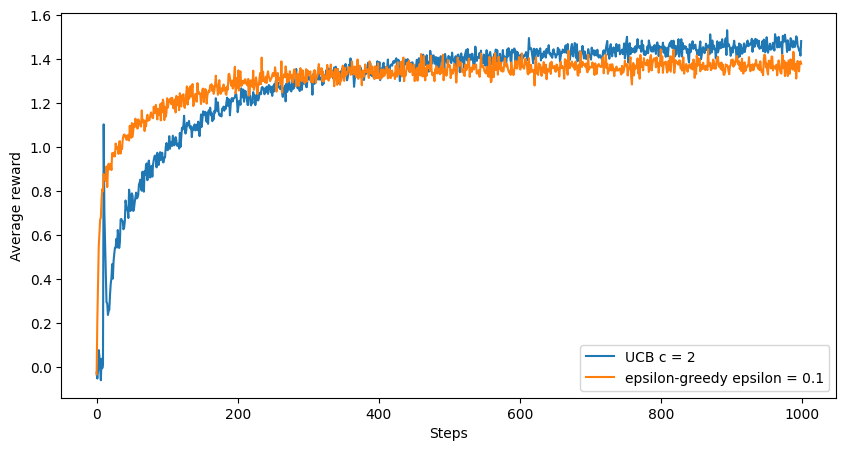

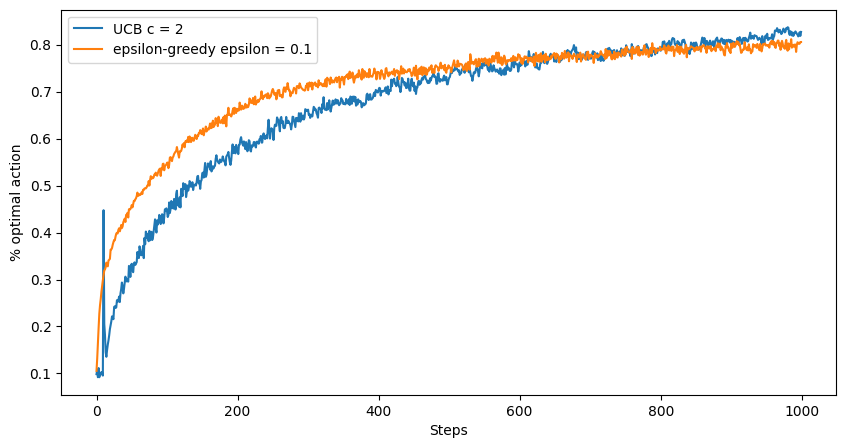

In [28]:
plt.figure(figsize=(10,5))
plt.plot(rewards_UCB[0], label='UCB c = 2')
plt.plot(rewards_UCB[1] , label='epsilon-greedy epsilon = 0.1')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(best_action_counts_UCB[0], label='UCB c = 2')
plt.plot(best_action_counts_UCB[1], label='epsilon-greedy epsilon = 0.1')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend() 
plt.show()
plt.close()

## Gradient 

In [33]:
bandits_grad = []
bandits_grad.append(Bandit(strategy = 'gradient'))
bandits_grad.append(Bandit(strategy='gradient', alpha = 0.4))
best_action_counts_grad, rewards_grad = simulate(runs, time, bandits_grad)

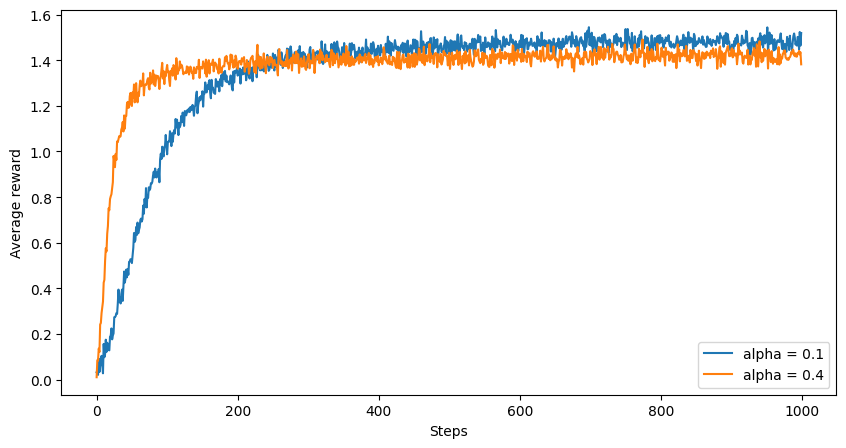

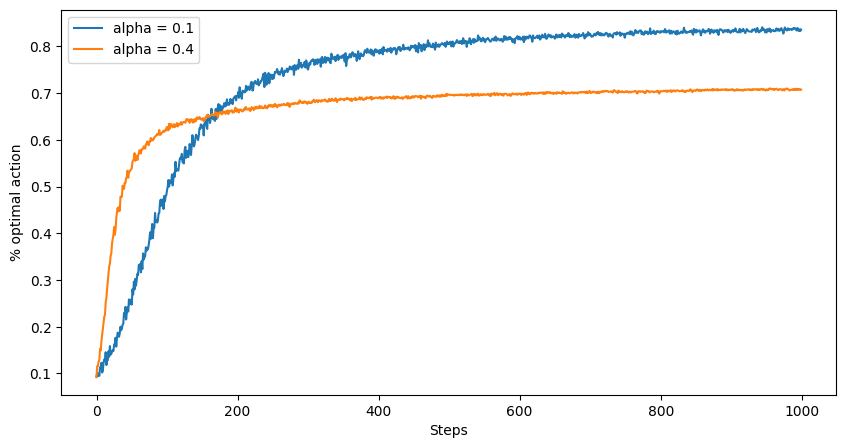

In [34]:
plt.figure(figsize=(10,5))
plt.plot(rewards_grad[0], label='alpha = 0.1')
plt.plot(rewards_grad[1], label='alpha = 0.4')

plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10,5))
plt.plot(best_action_counts_grad[0], label='alpha = 0.1')
plt.plot(best_action_counts_grad[1], label='alpha = 0.4')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend() 
plt.show()
plt.close()